In [1]:
%pip install pandas scikit-learn imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

# Load the training dataset
file_path = r'D:\Internship tasks\Credit Risk Analysis\Dataset\GiveMeSomeCredit-training.csv'
df_train = pd.read_csv(file_path)

# Inspect the first few rows to understand the structure
df_train.head()


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


Missing Values

In [3]:
# Check for missing values
missing_values = df_train.isnull().sum()

# Check the class distribution in the target variable 'SeriousDlqin2yrs'
class_distribution = df_train['SeriousDlqin2yrs'].value_counts()

missing_values, class_distribution


(Unnamed: 0                                  0
 SeriousDlqin2yrs                            0
 RevolvingUtilizationOfUnsecuredLines        0
 age                                         0
 NumberOfTime30-59DaysPastDueNotWorse        0
 DebtRatio                                   0
 MonthlyIncome                           29731
 NumberOfOpenCreditLinesAndLoans             0
 NumberOfTimes90DaysLate                     0
 NumberRealEstateLoansOrLines                0
 NumberOfTime60-89DaysPastDueNotWorse        0
 NumberOfDependents                       3924
 dtype: int64,
 SeriousDlqin2yrs
 0    139974
 1     10026
 Name: count, dtype: int64)

In [4]:
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.

Training XGBoost...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Training Random Forest...
Fitting 3 folds for each of 3 candidates, totalling 9 fits

XGBoost Performance:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91     27995
           1       0.24      0.62      0.34      2005

    accuracy                           0.84     30000
   macro avg       0.60      0.74      0.63     30000
weighted avg       0.92      0.84      0.87     30000

ROC AUC: 0.8300


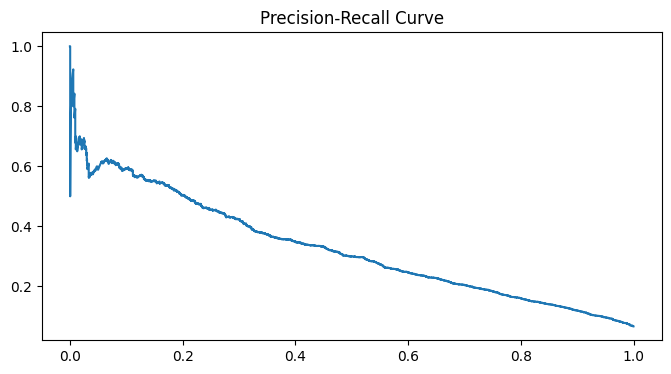

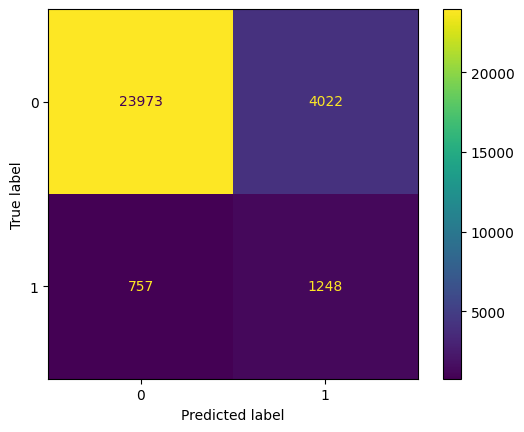


Optimal Threshold: 0.4773

Optimized XGBoost Performance:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90     27995
           1       0.23      0.65      0.34      2005

    accuracy                           0.83     30000
   macro avg       0.60      0.75      0.62     30000
weighted avg       0.92      0.83      0.86     30000

ROC AUC: 0.8300


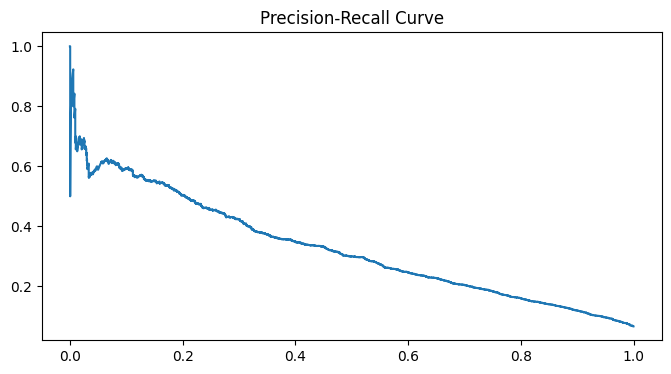

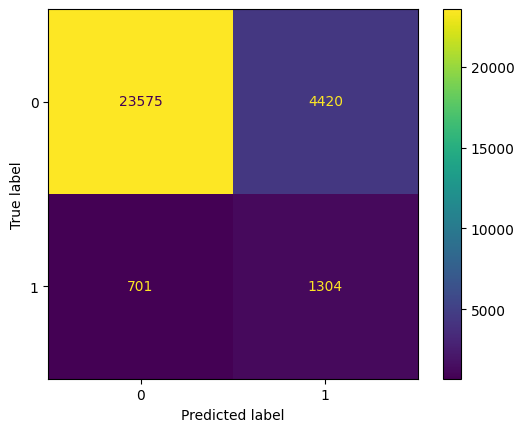

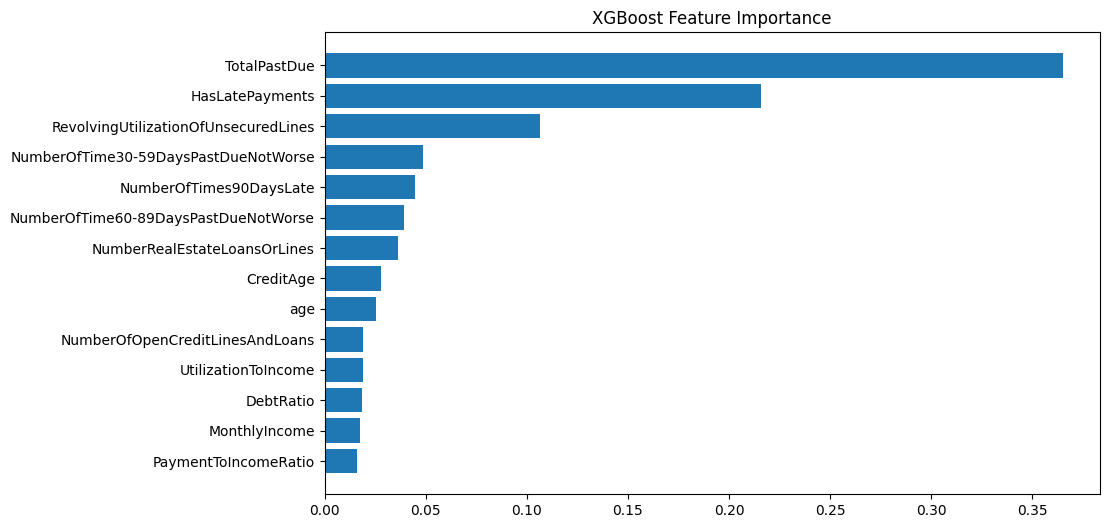

In [8]:
%pip install xgboost imbalanced-learn scikit-learn numpy pandas matplotlib --quiet

import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, 
                             roc_auc_score,
                             precision_recall_curve,
                             ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

# ----------------------
# DATA PREPROCESSING
# ----------------------
def load_and_preprocess(file_path):
    df = pd.read_csv(file_path)
    
    # Handle missing values
    df.fillna(df.median(), inplace=True)
    
    # Feature engineering
    df['PaymentToIncomeRatio'] = df['MonthlyIncome'] / (df['DebtRatio'] + 1e-6)
    df['CreditAge'] = df['age'] - 18
    df['TotalPastDue'] = (df['NumberOfTime30-59DaysPastDueNotWorse'] +
                         df['NumberOfTime60-89DaysPastDueNotWorse'] +
                         df['NumberOfTimes90DaysLate'])
    df['HasLatePayments'] = (df['TotalPastDue'] > 0).astype(int)
    df['UtilizationToIncome'] = df['RevolvingUtilizationOfUnsecuredLines'] * df['MonthlyIncome']
    
    # Target and features
    X = df.drop(['Unnamed: 0', 'SeriousDlqin2yrs', 'NumberOfDependents'], axis=1)
    y = df['SeriousDlqin2yrs']
    
    return X, y

# ----------------------
# MODEL TRAINING
# ----------------------
def train_model(X_train, y_train, model_type='xgb'):
    if model_type == 'xgb':
        # Calculate class weight
        scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
        
        model = XGBClassifier(
            objective='binary:logistic',
            eval_metric='aucpr',
            n_jobs=-1
        )
        params = {
            'learning_rate': [0.05, 0.1],
            'max_depth': [4, 6],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.7, 0.9],
            'scale_pos_weight': [scale_pos_weight],
            'n_estimators': [200]
        }
    else:
        model = RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-1)
        params = {
            'n_estimators': [150],
            'max_depth': [12, 15],
            'min_samples_split': [5, 10],
            'max_features': ['sqrt']
        }
    
    search = RandomizedSearchCV(
        model, params,
        n_iter=5 if model_type == 'xgb' else 3,
        scoring='roc_auc',
        cv=3,
        verbose=1,
        n_jobs=-1
    )
    search.fit(X_train, y_train)
    return search.best_estimator_

# ----------------------
# EVALUATION
# ----------------------
def evaluate_model(model, X_val, y_val, threshold=0.5):
    y_proba = model.predict_proba(X_val)[:,1]
    y_pred = (y_proba >= threshold).astype(int)
    
    print(classification_report(y_val, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_val, y_proba):.4f}")
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_val, y_proba)
    plt.figure(figsize=(8,4))
    plt.plot(recall, precision)
    plt.title('Precision-Recall Curve')
    plt.show()
    
    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
    plt.show()
    
    return y_proba

# ----------------------
# MAIN WORKFLOW
# ----------------------
if __name__ == "__main__":
    # Load data
    X, y = load_and_preprocess(r'D:\Internship tasks\Credit Risk Analysis\Dataset\GiveMeSomeCredit-training.csv')
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42,
        stratify=y
    )
    
    # Handle imbalance
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_train, y_train)
    
    # Train models
    print("\nTraining XGBoost...")
    xgb_model = train_model(X_res, y_res, 'xgb')
    
    print("\nTraining Random Forest...")
    rf_model = train_model(X_res, y_res, 'rf')
    
    # Evaluate XGBoost
    print("\nXGBoost Performance:")
    xgb_proba = evaluate_model(xgb_model, X_val, y_val)
    
    # Optimize threshold
    precision, recall, thresholds = precision_recall_curve(y_val, xgb_proba)
    f2_scores = (5 * precision * recall) / (4 * precision + recall + 1e-6)
    optimal_threshold = thresholds[np.argmax(f2_scores)]
    
    print(f"\nOptimal Threshold: {optimal_threshold:.4f}")
    print("\nOptimized XGBoost Performance:")
    evaluate_model(xgb_model, X_val, y_val, optimal_threshold)
    
    # Feature Importance
    plt.figure(figsize=(10,6))
    sorted_idx = xgb_model.feature_importances_.argsort()
    plt.barh(X.columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])
    plt.title("XGBoost Feature Importance")
    plt.show()